In [1]:
! pip install glove-python-binary

In [2]:
import os
import re

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from glove import Corpus, Glove

from sklearn.metrics import accuracy_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
train_data = pd.read_csv('C:/Users/dssalpc/Downloads/RF_mobilehealth/revision_data/traindata_2015_2018_beforeCovid.csv')

In [12]:
train_data = train_data.dropna()

In [13]:
reviews = list(train_data['clean_review'])
sentiments = list(train_data['sentiment'])

In [14]:
token = []
for review in reviews:
    token.append(review.split())

In [15]:
#Glove Corpus 생성
corpus = Corpus()
corpus.fit(token, window=20)

In [16]:
# model
glove = Glove(no_components=128, learning_rate=0.01)     
%time glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=False)    
glove.add_dictionary(corpus.dictionary)

# save
glove.save('./glove_w20_epoch50.model')

Wall time: 12.7 s


In [17]:
# load glove
glove_model = Glove.load('./glove_w20_epoch50.model')

# word dict 생성
word_dict = {}
for word in  glove_model.dictionary.keys():
    word_dict[word] = glove_model.word_vectors[glove_model.dictionary[word]]
print('[Success !] Lengh of word dict... : ', len(word_dict))

[Success !] Lengh of word dict... :  8863


In [18]:
# save word_dict
import pickle
with open('./glove_word_dict_128.pickle', 'wb') as f:
    pickle.dump(word_dict, f)
print('[Success !] Save word dict!...')

[Success !] Save word dict!...


In [20]:
# test data 임베딩 준비
TEST_CLEAN_DATA = 'test_clean.csv'

test_data = pd.read_csv('C:/Users/dssalpc/Downloads/RF_mobilehealth/revision_data/testdata_2019_beforeCovid.csv')
test_data = test_data.dropna()
test_reviews = list(test_data['contents'])

In [21]:
test_tokens = []
for review in test_reviews:
    test_tokens.append(review.split())

In [22]:
# test data 워드 임베딩 // ...?왜한걸까..?
# word dict : train데이터의 임베딩 사전
total_word_dict = {}
cnt = 0

for word in test_tokens:
    for i in range(len(word)):
        if word[i] in word_dict.keys():
            total_word_dict[word[i]] = word_dict[word[i]]
        else:
            word_dict[word[i]] = np.zeros((128))
            cnt += 1  # 처음 본 단어 갯수 세기

print('no train word -> 0....', cnt)
print('token -> word embedding....!',len(total_word_dict))

no train word -> 0.... 20153
token -> word embedding....! 8990


In [23]:
# embedding
def sent2vec_glove(tokens, embedding_dim=128):
    '''문장 token 리스트를 받아서 임베딩 시킨다.'''
  
    size = len(tokens)
    matrix = np.zeros((size, embedding_dim))
    word_table = word_dict     # glove word_dict

    for i, token in enumerate(tokens):
        vector = np.array([
            word_table[t] for t in token
            if t in word_table
        ])

        if vector.size != 0:
            final_vector = np.mean(vector, axis=0)
            matrix[i] = final_vector

    return matrix

In [24]:
# 문장 임베딩
sentence_glove = sent2vec_glove(reviews)
sentence_glove.shape

(31312, 128)

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train = sentence_glove
y_train = np.array(sentiments)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_list = {'max_depth': [10, 20, 30, 40, 50],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000]
}

rf_model = RandomForestClassifier(random_state = 82)

forest = GridSearchCV(
        estimator=rf_model,
        param_grid = param_list,
        cv = 5,
        n_jobs = -1,
        scoring = 'accuracy',
        verbose = 2)

forest.fit(x_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=82), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             scoring='accuracy', verbose=2)

In [27]:
sentence_glove = sent2vec_glove(test_reviews)

test_input = sentence_glove

In [28]:
realAnswer = list(test_data['sentiment'])
test_label = np.array(realAnswer)

In [29]:
rf_pred = forest.predict(test_input)

In [30]:
print("Accuracy: %f" % accuracy_score(test_label, rf_pred))

Accuracy: 0.738598


Text(0.5, 257.44, 'Predicted label')

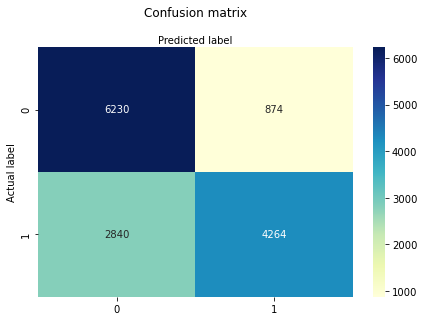

In [31]:
cnf_matrix = metrics.confusion_matrix(test_label, rf_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [32]:
print("Accuracy:",metrics.accuracy_score(test_label, rf_pred))
print("Precision:",metrics.precision_score(test_label, rf_pred))
print("Recall:",metrics.recall_score(test_label, rf_pred))

Accuracy: 0.738597972972973
Precision: 0.8298949007395874
Recall: 0.6002252252252253


In [39]:
import joblib

# 모델 저장
joblib.dump(forest, 'C:/Users/dssalpc/Downloads/RF_mobilehealth/rf_glove_with_gridsearch_beforeCovid.pkl')

# 모델 불러오기
rf_model = joblib.load('C:/Users/dssalpc/Downloads/RF_mobilehealth/rf_glove_with_gridsearch_beforeCovid.pkl')

In [40]:
rf_model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=82), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             scoring='accuracy', verbose=2)

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf_model.predict(test_input)
predictions = [value for value in y_pred]

accuracy_score(test_label, predictions)

0.738597972972973

In [42]:
from sklearn.metrics import classification_report

report = classification_report(test_label, y_pred, target_names=['class low', 'class high'], output_dict=True)
df = pd.DataFrame(report).transpose()

df

,precision,recall,f1-score,support
class low,0.686880,0.876971,0.770372,7104.000000
class high,0.829895,0.600225,0.696618,7104.000000
accuracy,0.738598,0.738598,0.738598,0.738598
macro avg,0.758387,0.738598,0.733495,14208.000000
weighted avg,0.758387,0.738598,0.733495,14208.000000


In [43]:
forest.best_params_

{'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}